# Diabetes Risk Prediction

This notebook builds a machine learning pipeline to predict whether a patient is at risk for diabetes using the PIMA Indian dataset.

Goals:
- Perform EDA and handle missing/invalid values
- Build a strong preprocessing pipeline with feature engineering
- Compare multiple models (LogReg, RF, XGBoost, Neural Net)
- Visualize model performance (ROC, AUC, feature importance)
- Explain predictions with SHAP
- Train a Neural Network


In [1]:
!pip install scikit-learn xgboost shap matplotlib pandas seaborn joblib --quiet

## Exploratory Data Analysis

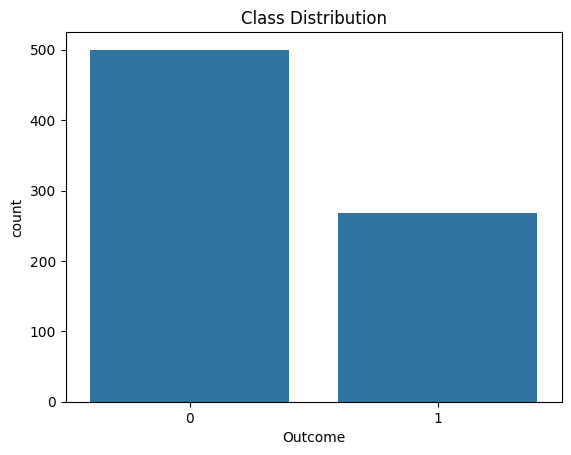

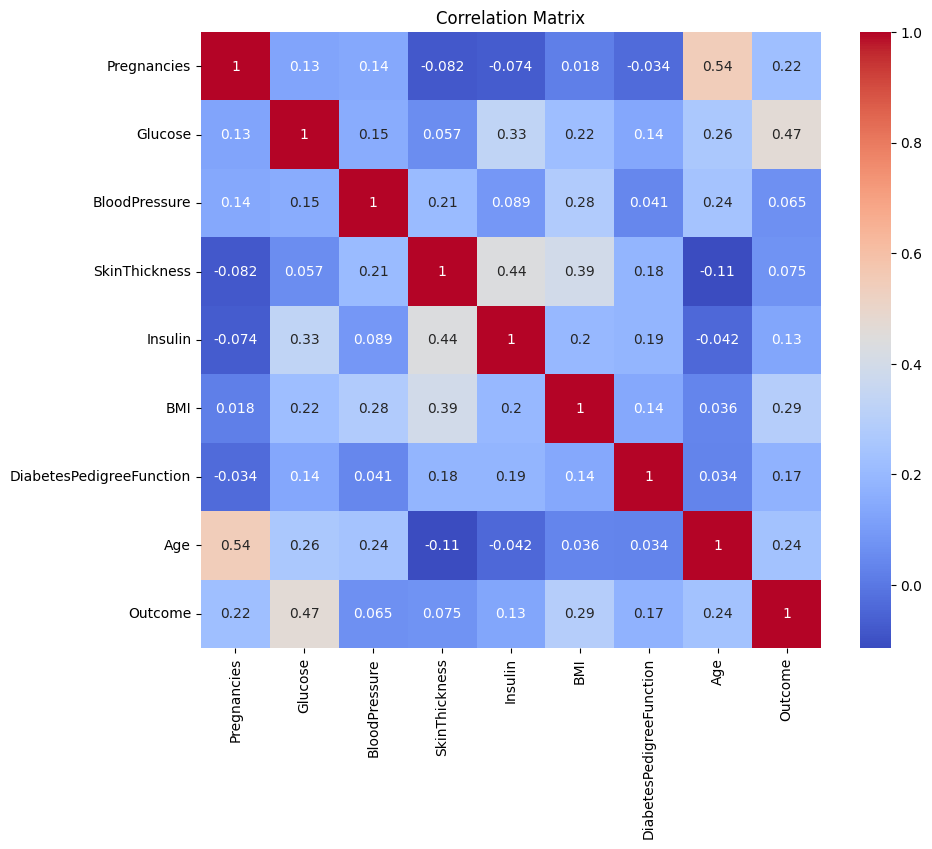

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
           "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
df = pd.read_csv(url, names=columns)

sns.countplot(data=df, x='Outcome')
plt.title("Class Distribution")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Feature Engineering and Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

df_cleaned = df.copy()
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in zero_features:
    df_cleaned[col] = df_cleaned[col].replace(0, np.nan)
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

df_cleaned["BMI_Age"] = df_cleaned["BMI"] * df_cleaned["Age"]
df_cleaned["GlucosePerPreg"] = df_cleaned["Glucose"] / (df_cleaned["Pregnancies"] + 1)
df_cleaned["LogInsulin"] = np.log1p(df_cleaned["Insulin"])
df_cleaned["LogBMI"] = np.log1p(df_cleaned["BMI"])

drop_cols = ["Insulin", "BMI"]
X = df_cleaned.drop(columns=["Outcome"] + drop_cols)
y = df_cleaned["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "scaler.pkl")

/tmp/ipython-input-3-6493690.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)


['scaler.pkl']

## Train Machine Learning Models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

predictions = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    predictions[name] = y_prob
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name}: ROC AUC = {auc:.4f}")

joblib.dump(models["XGBoost"], "xgboost_diabetes_model.pkl")

Logistic Regression: ROC AUC = 0.8233
Random Forest: ROC AUC = 0.8241


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:45:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: ROC AUC = 0.7842


['xgboost_diabetes_model.pkl']

## ROC Curve Comparison

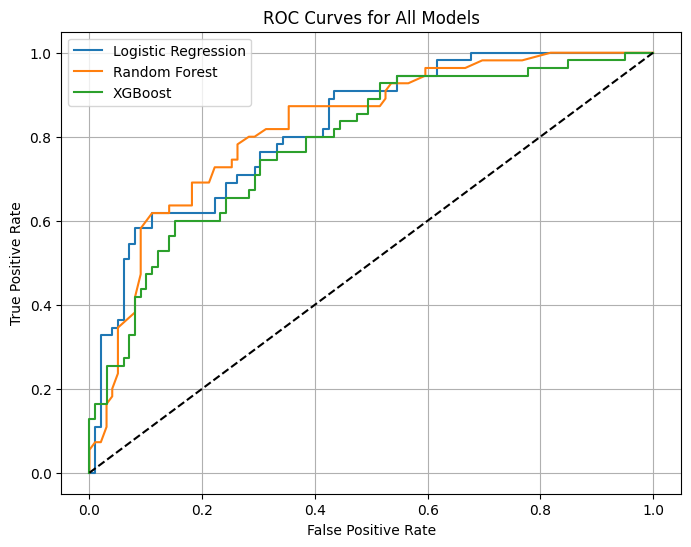

In [5]:
plt.figure(figsize=(8,6))
for name, y_prob in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()

## Explainability with SHAP

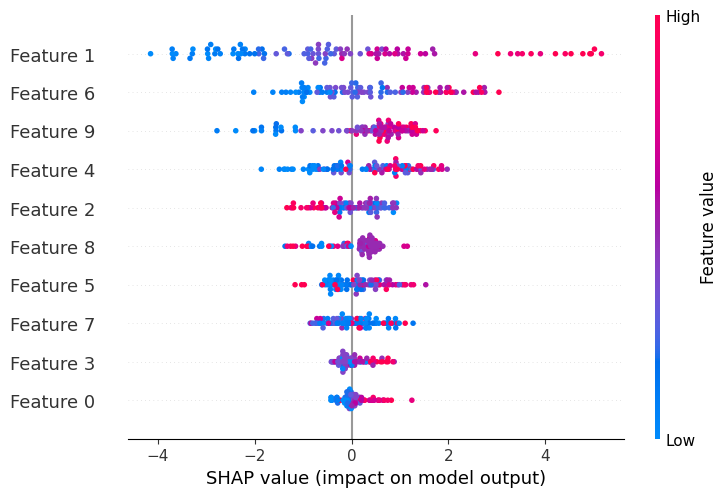

In [6]:
import shap
explainer = shap.Explainer(models["XGBoost"], X_train_scaled)
shap_values = explainer(X_test_scaled[:100])
shap.plots.beeswarm(shap_values)

## Neural Network Model (PyTorch)

In [8]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train_scaled.shape[1], 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dl = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

nn_model = MLP()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

for epoch in range(15):
    nn_model.train()
    total_loss = 0
    for xb, yb in train_dl:
        preds = nn_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation with ROC AUC
    nn_model.eval()
    with torch.no_grad():
        test_logits = nn_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits).numpy().flatten()
        test_labels = y_test_tensor.numpy().flatten()
        auc = roc_auc_score(test_labels, test_probs)

    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(train_dl):.4f}, ROC AUC = {auc:.4f}")

Epoch 1: Avg Loss = 0.7123, ROC AUC = 0.7517
Epoch 2: Avg Loss = 0.6776, ROC AUC = 0.7871
Epoch 3: Avg Loss = 0.6310, ROC AUC = 0.7950
Epoch 4: Avg Loss = 0.5701, ROC AUC = 0.7996
Epoch 5: Avg Loss = 0.5035, ROC AUC = 0.8125
Epoch 6: Avg Loss = 0.4718, ROC AUC = 0.8174
Epoch 7: Avg Loss = 0.4652, ROC AUC = 0.8241
Epoch 8: Avg Loss = 0.4473, ROC AUC = 0.8268
Epoch 9: Avg Loss = 0.4417, ROC AUC = 0.8307
Epoch 10: Avg Loss = 0.4425, ROC AUC = 0.8307
Epoch 11: Avg Loss = 0.4366, ROC AUC = 0.8307
Epoch 12: Avg Loss = 0.4336, ROC AUC = 0.8345
Epoch 13: Avg Loss = 0.4326, ROC AUC = 0.8345
Epoch 14: Avg Loss = 0.4311, ROC AUC = 0.8334
Epoch 15: Avg Loss = 0.4276, ROC AUC = 0.8332
